## XGBoost
smote로 imbalanced sample 문제 해결<br>
for문을 이용해 hyperparameter 결정<br>
결정된 hyperparameter로 모델 학습 후 bin 파일로 저장<br>
결정된 모델에 대해 feature importance 추출

### 기본 세팅

In [1]:
!pip install xgboost
import xgboost as xgb
import numpy as np
import math
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 성능 평가를 위해 임의 제작한 함수
def get_clf_eval(y_test, params, pred=None, pred_proba_po=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred_proba_po)
    
    result.append([params["max_depth"], params["eta"], accuracy, precision, recall, f1, auc])
    
    print("-------------------------------")
    print("<< XGBoost Model >>")
    print("오차 행렬")
    print(confusion)
    print(f"정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

### 데이터 전처리

In [3]:
lcDataFrame = pd.read_stata('./lendingclub_train.dta')

In [4]:
def concatTwoDataFrames(df1,df2):
    namesOf2 = df2.columns.tolist()
    for name in namesOf2:
        df1[name] = df2[name]
    return df1

In [5]:
def deleteColumnsFromDataFrame(df, L):
    if type(L) == list:
        newDf = df.drop(columns=[]+L)
    elif type(L) == str:
        newDf = df.drop(columns=[L])
    return newDf

In [6]:
def deleteRowFromDataFrame(df, index):
    newDf = df.drop([index], axis=0)
    return newDf

In [7]:
def getDigitList(df, str):
    bucket = []
    for data in df[str]:
        if data != 0:
            bucket.append(1)
        else:
            bucket.append(0)
    return bucket

In [8]:
def eliminateColumn(df, str):
    names_column = df.columns.tolist()
    if str in names_column:
        print('eliminate start ...')
        newDf = df.drop(columns=[str])
        print('eliminate complete.')
        return newDf
    else:
        return df

In [9]:
def getDigitList(df, str):
    bucket = []
    for data in df[str]:
        if data != 0:
            bucket.append(1)
        else:
            bucket.append(0)
    return bucket

In [10]:
def getDigitizedDf(df):
    copyDf = df.copy()  
    names_column = copyDf.columns.tolist()
    names_tobe_digitize = ['delinq_2yrs', 
                           'pub_rec', 
                           'revol_bal', 
                           'collections_12_mths_ex_med', 
                           'pub_rec_bankruptcies', 
                           'tax_liens']
    
    if all(elm in names_column for elm in names_tobe_digitize):
        print('digitize start ...')
        for name in names_tobe_digitize:
            copyDf[name] = getDigitList(copyDf, name)
        print('digitize complete.')
        return copyDf
    else:
        print('digitize failed')
        print('return input data')
        return df

In [11]:
def scaleLog2(df, name):
    bucket = []
    for x in df[name]:
        bucket.append(math.log2(x+1))
    return bucket

In [12]:
def getDataScaledByLog(df):
    copy = df.copy()
    names_tobe_log = ['annual_inc', 'open_acc', 'pub_rec', 'revol_util', 'total_acc']
    print('scale start ...')
    for name in names_tobe_log:
        df[name] = scaleLog2(copy, name)
    print('scale complete.')
    return df

In [13]:
def getInitials(df):
    copy = df.copy()
    names_initial = [
 'loan_amnt',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'fico_range_high',
 'fico_range_low',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'collections_12_mths_ex_med',
 'inq_last_6mths',
 'pub_rec_bankruptcies',
 'tax_liens',
 'term1',
 'emp_length1',
 'emp_length2',
 'emp_length3',
 'emp_length4',
 'emp_length5',
 'emp_length6',
 'emp_length7',
 'emp_length8',
 'emp_length9',
 'emp_length10',
 'emp_length11',
 'emp_length12',
 'home_ownership1',
 'home_ownership2',
 'home_ownership3',
 'home_ownership4',
 'home_ownership5',
 'home_ownership6',
 'purpose1',
 'purpose2',
 'purpose3',
 'purpose4',
 'purpose5',
 'purpose6',
 'purpose7',
 'purpose8',
 'purpose9',
 'purpose10',
 'purpose11',
 'purpose12',
 'purpose13',
 'purpose14',
 'addr_state1',
 'addr_state2',
 'addr_state3',
 'addr_state4',
 'addr_state5',
 'addr_state6',
 'addr_state7',
 'addr_state8',
 'addr_state9',
 'addr_state10',
 'addr_state11',
 'addr_state12',
 'addr_state13',
 'addr_state14',
 'addr_state15',
 'addr_state16',
 'addr_state17',
 'addr_state18',
 'addr_state19',
 'addr_state20',
 'addr_state21',
 'addr_state22',
 'addr_state23',
 'addr_state24',
 'addr_state25',
 'addr_state26',
 'addr_state27',
 'addr_state28',
 'addr_state29',
 'addr_state30',
 'addr_state31',
 'addr_state32',
 'addr_state33',
 'addr_state34',
 'addr_state35',
 'addr_state36',
 'addr_state37',
 'addr_state38',
 'addr_state39',
 'addr_state40',
 'addr_state41',
 'addr_state42',
 'addr_state43',
 'addr_state44',
 'addr_state45',
 'addr_state46',
 'addr_state47',
 'addr_state48',
 'addr_state49',
 'addr_state50',
 'addr_state51',
 'mths_since_last_delinq1',
 'mths_since_last_delinq2',
 'mths_since_last_delinq3',
 'mths_since_last_delinq4',
 'mths_since_last_delinq5',
 'mths_since_last_delinq6',
 'mths_since_last_delinq7',
 'mths_since_last_delinq8',
 'mths_since_last_delinq9',
 'mths_since_last_delinq10',
 'mths_since_last_delinq11',
 'mths_since_last_major_derog1',
 'mths_since_last_major_derog2',
 'mths_since_last_major_derog3',
 'mths_since_last_major_derog4',
 'mths_since_last_major_derog5',
 'mths_since_last_major_derog6',
 'mths_since_last_major_derog7',
 'mths_since_last_major_derog8',
 'mths_since_last_major_derog9',
 'mths_since_last_major_derog10',
 'mths_since_last_major_derog11',
 'mths_since_last_record1',
 'mths_since_last_record2',
 'mths_since_last_record3',
 'mths_since_last_record4',
 'mths_since_last_record5',
 'mths_since_last_record6',
 'mths_since_last_record7',
 'mths_since_last_record8',
 'mths_since_last_record9',
 'mths_since_last_record10',
 'mths_since_last_record11',
 'mths_since_rcnt_il1',
 'mths_since_rcnt_il2',
 'mths_since_rcnt_il3',
 'mths_since_rcnt_il4',
 'mths_since_rcnt_il5',
 'mths_since_rcnt_il6',
 'mths_since_rcnt_il7',
 'mths_since_rcnt_il8',
 'mths_since_rcnt_il9',
 'mths_since_rcnt_il10',
 'mths_since_rcnt_il11',
 'mths_since_recent_bc1',
 'mths_since_recent_bc2',
 'mths_since_recent_bc3',
 'mths_since_recent_bc4',
 'mths_since_recent_bc5',
 'mths_since_recent_bc6',
 'mths_since_recent_bc7',
 'mths_since_recent_bc8',
 'mths_since_recent_bc9',
 'mths_since_recent_bc10',
 'mths_since_recent_bc11',
 'mths_since_recent_bc_dlq1',
 'mths_since_recent_bc_dlq2',
 'mths_since_recent_bc_dlq3',
 'mths_since_recent_bc_dlq4',
 'mths_since_recent_bc_dlq5',
 'mths_since_recent_bc_dlq6',
 'mths_since_recent_bc_dlq7',
 'mths_since_recent_bc_dlq8',
 'mths_since_recent_bc_dlq9',
 'mths_since_recent_bc_dlq10',
 'mths_since_recent_bc_dlq11',
 'mths_since_recent_inq1',
 'mths_since_recent_inq2',
 'mths_since_recent_inq3',
 'mths_since_recent_inq4',
 'mths_since_recent_inq5',
 'mths_since_recent_inq6',
 'mths_since_recent_inq7',
 'mths_since_recent_inq8',
 'mths_since_recent_inq9',
 'mths_since_recent_inq10',
 'mths_since_recent_revol_delinq1',
 'mths_since_recent_revol_delinq2',
 'mths_since_recent_revol_delinq3',
 'mths_since_recent_revol_delinq4',
 'mths_since_recent_revol_delinq5',
 'mths_since_recent_revol_delinq6',
 'mths_since_recent_revol_delinq7',
 'mths_since_recent_revol_delinq8',
 'mths_since_recent_revol_delinq9',
 'mths_since_recent_revol_delinq10',
 'mths_since_recent_revol_delinq11']
    newDf = pd.DataFrame()
    for name in names_initial:
        newDf[name] = copy[name]
    return newDf

In [14]:
def preprocess_initial(rawDataFrame):
    copy = rawDataFrame.copy()
    # initial 변수만 남기기
    df = getInitials(copy)
    # 행 지우기
    df = deleteRowFromDataFrame(df, 831698)
    # 열 지우기
    df = eliminateColumn(df, 'fico_range_high')
    # 리턴
    return df

In [15]:
def preprocess_scale_digitize(rawDataFrame):
    copy = rawDataFrame.copy()
    # initial 변수만 남기기
    df = getInitials(copy)
    # 행 지우기
    df = deleteRowFromDataFrame(df, 831698)
    # 열 지우기
    df = eliminateColumn(df, 'fico_range_high')
    # 이진화
    df = getDigitizedDf(df)
    # 로그스케일링
    df = getDataScaledByLog(df)
    # 리턴
    return df

In [16]:
def preprocess_y(rawDataFrame):
    copy = rawDataFrame.copy()
    df = copy[['depvar']]
    df = deleteRowFromDataFrame(df, 831698)
    return df

In [17]:
X_initial = preprocess_initial(lcDataFrame)

eliminate start ...
eliminate complete.


In [18]:
scaled_digitized_X_initial = preprocess_scale_digitize(lcDataFrame)

eliminate start ...
eliminate complete.
digitize start ...
digitize complete.
scale start ...
scale complete.


In [19]:
y = preprocess_y(lcDataFrame)

In [20]:
X_initial

,loan_amnt,annual_inc,dti,delinq_2yrs,fico_range_low,open_acc,pub_rec,revol_bal,revol_util,total_acc,...,mths_since_recent_revol_delinq2,mths_since_recent_revol_delinq3,mths_since_recent_revol_delinq4,mths_since_recent_revol_delinq5,mths_since_recent_revol_delinq6,mths_since_recent_revol_delinq7,mths_since_recent_revol_delinq8,mths_since_recent_revol_delinq9,mths_since_recent_revol_delinq10,mths_since_recent_revol_delinq11
0,12000,90641.0,10.20,0,690,5,0,5673,0.405,20,...,0,0,0,0,0,0,0,0,0,0
1,14000,46000.0,17.40,1,670,9,0,10285,0.664,18,...,0,0,0,1,0,0,0,0,0,0
2,24000,90000.0,11.73,2,660,6,0,18989,0.474,10,...,0,0,0,0,0,0,0,0,0,0
3,14000,115000.0,7.31,0,660,16,0,16451,0.401,22,...,0,0,0,0,0,0,0,0,0,0
4,14000,78000.0,24.32,0,685,17,0,25930,0.534,30,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874330,32000,90000.0,27.39,0,735,14,0,91190,0.813,17,...,0,0,0,0,0,0,0,0,0,0
874331,24000,76000.0,34.20,0,685,16,0,38338,0.844,24,...,0,0,0,0,0,0,0,0,0,0
874332,4000,24960.0,25.29,0,790,15,0,3397,0.092,26,...,0,0,0,0,0,0,0,0,0,0
874333,8000,53000.0,18.07,2,680,10,1,3304,0.370,24,...,0,0,0,1,0,0,0,0,0,0


In [21]:
scaled_digitized_X_initial

,loan_amnt,annual_inc,dti,delinq_2yrs,fico_range_low,open_acc,pub_rec,revol_bal,revol_util,total_acc,...,mths_since_recent_revol_delinq2,mths_since_recent_revol_delinq3,mths_since_recent_revol_delinq4,mths_since_recent_revol_delinq5,mths_since_recent_revol_delinq6,mths_since_recent_revol_delinq7,mths_since_recent_revol_delinq8,mths_since_recent_revol_delinq9,mths_since_recent_revol_delinq10,mths_since_recent_revol_delinq11
0,12000,16.467892,10.20,0,690,2.584963,0.0,1,0.490570,4.392317,...,0,0,0,0,0,0,0,0,0,0
1,14000,15.489378,17.40,1,670,3.321928,0.0,1,0.734655,4.247928,...,0,0,0,1,0,0,0,0,0,0
2,24000,16.457653,11.73,1,660,2.807355,0.0,1,0.559737,3.459432,...,0,0,0,0,0,0,0,0,0,0
3,14000,16.811287,7.31,0,660,4.087463,0.0,1,0.486457,4.523562,...,0,0,0,0,0,0,0,0,0,0
4,14000,16.251205,24.32,0,685,4.169925,0.0,1,0.617298,4.954196,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874330,32000,16.457653,27.39,0,735,3.906891,0.0,1,0.858379,4.169925,...,0,0,0,0,0,0,0,0,0,0
874331,24000,16.213731,34.20,0,685,4.087463,0.0,1,0.882839,4.643856,...,0,0,0,0,0,0,0,0,0,0
874332,4000,14.607388,25.29,0,790,4.000000,0.0,1,0.126973,4.754888,...,0,0,0,0,0,0,0,0,0,0
874333,8000,15.693732,18.07,1,680,3.459432,1.0,1,0.454176,4.643856,...,0,0,0,1,0,0,0,0,0,0


In [22]:
y

,depvar
0,1.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
874330,0.0
874331,0.0
874332,0.0
874333,0.0


### Imbalanced data의 문제 해결을 위해 smote로 oversampling 적용

In [23]:
!pip install imblearn #라이브러리 설치
from imblearn.over_sampling import RandomOverSampler # 라이브러리 불러오기
ros = RandomOverSampler(random_state=100) # 오버샘플러 객체 생성
X_train_initial, X_test_initial, y_train_initial, y_test_initial = train_test_split(X_initial, y, test_size=0.3, random_state=100) # 일단 데이터 분할부터 먼저 진행
pp_X_train_initial, pp_X_test_initial, pp_y_train_initial, pp_y_test_initial = train_test_split(scaled_digitized_X_initial, y, test_size=0.3, random_state=100) # 일단 데이터 분할부터 먼저 진행

X_train_initial, y_train_initial = ros.fit_resample(X_train_initial, y_train_initial) # 분할된 데이터 중 훈련데이터만 오버샘플링하고 테스트데이터는 오버샘플링을 적용하지 않음
pp_X_train_initial, pp_y_train_initial = ros.fit_resample(pp_X_train_initial, pp_y_train_initial) # 분할된 데이터 중 훈련데이터만 오버샘플링하고 테스트데이터는 오버샘플링을 적용하지 않음


### 적합한 hyperparameter 선택
for문을 이용해 max_depth, eta(학습률) 두 가지 hyperparameter를 세부 조정<br>
scaled, digitized 전, 후의 data를 모두 테스트 해 preprocessing이 적합한지도 함께 확인

In [24]:
# 결과를 한 눈에 보기 위한 리스트 추가
result = []
result.append(["max_depth", "eta", "accuracy", "precision", "recall", "f1", "auc"])

#### unpreprocessed

In [25]:
# 다양한 hyperparameter에 대해 모델을 돌려보고자 합니다. 
# max_depth: 모델의 complexity. 클수록 과적합의 위험이 있다. 
# eta: 학습률. 각 단게에서 가중치 조정 비율을 결정. 작을수록 더 많은 단계를 거쳐 최적화의 가능성이 있음. 단, 계산 비용도 같이 올라간다. 
num_rounds = 500

# XGBoost에서 사용하는 전용 데이터셋입니다. 
dtrain = xgb.DMatrix(data = X_train_initial, label = y_train_initial)
dtest = xgb.DMatrix(data = X_test_initial, label = y_test_initial)

wlist = [(dtrain, "train"), (dtest, "test")]

print("<< Unpreprocessed version of X >>")

for i in [3,6,9]:
    for j in [0.01,0.1,0.2]:
        params = {
            "max_depth":i,
            "eta":j,
            "objective":"binary:logistic",
            "eval_metric":"auc"
        }
        xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = num_rounds,evals = wlist)
        pred_probs = xgb_model.predict(dtest)
        preds = [1 if x > 0.5 else 0 for x in pred_probs]
        get_clf_eval(y_test_initial, params, pred = preds, pred_proba_po = pred_probs)

<< Unpreprocessed version of X >>
[0]	train-auc:0.61907	test-auc:0.61437
[1]	train-auc:0.62377	test-auc:0.61889
[2]	train-auc:0.62380	test-auc:0.61903
[3]	train-auc:0.62471	test-auc:0.61968
[4]	train-auc:0.62434	test-auc:0.61946
[5]	train-auc:0.62427	test-auc:0.61941
[6]	train-auc:0.62430	test-auc:0.61942
[7]	train-auc:0.62438	test-auc:0.61947
[8]	train-auc:0.62462	test-auc:0.61968
[9]	train-auc:0.62475	test-auc:0.61990
[10]	train-auc:0.62475	test-auc:0.61966
[11]	train-auc:0.62494	test-auc:0.62006
[12]	train-auc:0.62492	test-auc:0.61992
[13]	train-auc:0.62689	test-auc:0.62197
[14]	train-auc:0.62677	test-auc:0.62188
[15]	train-auc:0.62695	test-auc:0.62201
[16]	train-auc:0.62682	test-auc:0.62195
[17]	train-auc:0.62741	test-auc:0.62250
[18]	train-auc:0.63237	test-auc:0.62741
[19]	train-auc:0.63247	test-auc:0.62759
[20]	train-auc:0.63261	test-auc:0.62775
[21]	train-auc:0.63319	test-auc:0.62828
[22]	train-auc:0.63337	test-auc:0.62839
[23]	train-auc:0.63353	test-auc:0.62856
[24]	train-auc:0

[202]	train-auc:0.65802	test-auc:0.65208
[203]	train-auc:0.65810	test-auc:0.65215
[204]	train-auc:0.65816	test-auc:0.65220
[205]	train-auc:0.65825	test-auc:0.65230
[206]	train-auc:0.65835	test-auc:0.65241
[207]	train-auc:0.65843	test-auc:0.65249
[208]	train-auc:0.65852	test-auc:0.65256
[209]	train-auc:0.65859	test-auc:0.65262
[210]	train-auc:0.65868	test-auc:0.65271
[211]	train-auc:0.65873	test-auc:0.65275
[212]	train-auc:0.65879	test-auc:0.65281
[213]	train-auc:0.65885	test-auc:0.65287
[214]	train-auc:0.65895	test-auc:0.65298
[215]	train-auc:0.65905	test-auc:0.65307
[216]	train-auc:0.65913	test-auc:0.65314
[217]	train-auc:0.65924	test-auc:0.65326
[218]	train-auc:0.65933	test-auc:0.65336
[219]	train-auc:0.65940	test-auc:0.65342
[220]	train-auc:0.65946	test-auc:0.65347
[221]	train-auc:0.65953	test-auc:0.65354
[222]	train-auc:0.65962	test-auc:0.65364
[223]	train-auc:0.65971	test-auc:0.65374
[224]	train-auc:0.65978	test-auc:0.65379
[225]	train-auc:0.65984	test-auc:0.65385
[226]	train-auc:

[402]	train-auc:0.66937	test-auc:0.66327
[403]	train-auc:0.66941	test-auc:0.66331
[404]	train-auc:0.66944	test-auc:0.66333
[405]	train-auc:0.66947	test-auc:0.66337
[406]	train-auc:0.66953	test-auc:0.66343
[407]	train-auc:0.66958	test-auc:0.66348
[408]	train-auc:0.66960	test-auc:0.66349
[409]	train-auc:0.66964	test-auc:0.66352
[410]	train-auc:0.66970	test-auc:0.66359
[411]	train-auc:0.66976	test-auc:0.66366
[412]	train-auc:0.66979	test-auc:0.66368
[413]	train-auc:0.66981	test-auc:0.66371
[414]	train-auc:0.66984	test-auc:0.66373
[415]	train-auc:0.66989	test-auc:0.66378
[416]	train-auc:0.66993	test-auc:0.66382
[417]	train-auc:0.66998	test-auc:0.66386
[418]	train-auc:0.67004	test-auc:0.66393
[419]	train-auc:0.67007	test-auc:0.66396
[420]	train-auc:0.67009	test-auc:0.66399
[421]	train-auc:0.67012	test-auc:0.66401
[422]	train-auc:0.67016	test-auc:0.66406
[423]	train-auc:0.67021	test-auc:0.66410
[424]	train-auc:0.67027	test-auc:0.66415
[425]	train-auc:0.67030	test-auc:0.66418
[426]	train-auc:

[101]	train-auc:0.68222	test-auc:0.67527
[102]	train-auc:0.68233	test-auc:0.67537
[103]	train-auc:0.68244	test-auc:0.67550
[104]	train-auc:0.68256	test-auc:0.67558
[105]	train-auc:0.68272	test-auc:0.67576
[106]	train-auc:0.68280	test-auc:0.67582
[107]	train-auc:0.68295	test-auc:0.67593
[108]	train-auc:0.68298	test-auc:0.67592
[109]	train-auc:0.68310	test-auc:0.67602
[110]	train-auc:0.68319	test-auc:0.67608
[111]	train-auc:0.68329	test-auc:0.67615
[112]	train-auc:0.68339	test-auc:0.67619
[113]	train-auc:0.68358	test-auc:0.67640
[114]	train-auc:0.68376	test-auc:0.67656
[115]	train-auc:0.68387	test-auc:0.67668
[116]	train-auc:0.68402	test-auc:0.67681
[117]	train-auc:0.68408	test-auc:0.67685
[118]	train-auc:0.68416	test-auc:0.67694
[119]	train-auc:0.68422	test-auc:0.67700
[120]	train-auc:0.68430	test-auc:0.67705
[121]	train-auc:0.68439	test-auc:0.67713
[122]	train-auc:0.68454	test-auc:0.67729
[123]	train-auc:0.68462	test-auc:0.67732
[124]	train-auc:0.68468	test-auc:0.67736
[125]	train-auc:

[301]	train-auc:0.69415	test-auc:0.68434
[302]	train-auc:0.69418	test-auc:0.68434
[303]	train-auc:0.69420	test-auc:0.68436
[304]	train-auc:0.69423	test-auc:0.68437
[305]	train-auc:0.69427	test-auc:0.68440
[306]	train-auc:0.69431	test-auc:0.68441
[307]	train-auc:0.69435	test-auc:0.68442
[308]	train-auc:0.69437	test-auc:0.68443
[309]	train-auc:0.69445	test-auc:0.68451
[310]	train-auc:0.69451	test-auc:0.68458
[311]	train-auc:0.69454	test-auc:0.68459
[312]	train-auc:0.69459	test-auc:0.68462
[313]	train-auc:0.69461	test-auc:0.68464
[314]	train-auc:0.69463	test-auc:0.68465
[315]	train-auc:0.69465	test-auc:0.68465
[316]	train-auc:0.69469	test-auc:0.68468
[317]	train-auc:0.69471	test-auc:0.68469
[318]	train-auc:0.69473	test-auc:0.68472
[319]	train-auc:0.69476	test-auc:0.68473
[320]	train-auc:0.69478	test-auc:0.68473
[321]	train-auc:0.69481	test-auc:0.68474
[322]	train-auc:0.69483	test-auc:0.68474
[323]	train-auc:0.69486	test-auc:0.68476
[324]	train-auc:0.69489	test-auc:0.68478
[325]	train-auc:

[0]	train-auc:0.61907	test-auc:0.61437
[1]	train-auc:0.63209	test-auc:0.62758
[2]	train-auc:0.63565	test-auc:0.63089
[3]	train-auc:0.64224	test-auc:0.63672
[4]	train-auc:0.64365	test-auc:0.63800
[5]	train-auc:0.64776	test-auc:0.64182
[6]	train-auc:0.65015	test-auc:0.64385
[7]	train-auc:0.65370	test-auc:0.64736
[8]	train-auc:0.65468	test-auc:0.64839
[9]	train-auc:0.65581	test-auc:0.64985
[10]	train-auc:0.65789	test-auc:0.65181
[11]	train-auc:0.65912	test-auc:0.65334
[12]	train-auc:0.66070	test-auc:0.65488
[13]	train-auc:0.66121	test-auc:0.65541
[14]	train-auc:0.66319	test-auc:0.65745
[15]	train-auc:0.66443	test-auc:0.65858
[16]	train-auc:0.66534	test-auc:0.65955
[17]	train-auc:0.66621	test-auc:0.66034
[18]	train-auc:0.66724	test-auc:0.66143
[19]	train-auc:0.66854	test-auc:0.66286
[20]	train-auc:0.67020	test-auc:0.66461
[21]	train-auc:0.67050	test-auc:0.66491
[22]	train-auc:0.67118	test-auc:0.66543
[23]	train-auc:0.67148	test-auc:0.66560
[24]	train-auc:0.67229	test-auc:0.66634
[25]	train

[203]	train-auc:0.69679	test-auc:0.68555
[204]	train-auc:0.69689	test-auc:0.68562
[205]	train-auc:0.69697	test-auc:0.68569
[206]	train-auc:0.69700	test-auc:0.68569
[207]	train-auc:0.69704	test-auc:0.68572
[208]	train-auc:0.69708	test-auc:0.68573
[209]	train-auc:0.69711	test-auc:0.68574
[210]	train-auc:0.69717	test-auc:0.68575
[211]	train-auc:0.69720	test-auc:0.68576
[212]	train-auc:0.69726	test-auc:0.68576
[213]	train-auc:0.69735	test-auc:0.68581
[214]	train-auc:0.69738	test-auc:0.68582
[215]	train-auc:0.69744	test-auc:0.68584
[216]	train-auc:0.69750	test-auc:0.68591
[217]	train-auc:0.69757	test-auc:0.68594
[218]	train-auc:0.69763	test-auc:0.68600
[219]	train-auc:0.69767	test-auc:0.68603
[220]	train-auc:0.69771	test-auc:0.68605
[221]	train-auc:0.69776	test-auc:0.68608
[222]	train-auc:0.69780	test-auc:0.68607
[223]	train-auc:0.69784	test-auc:0.68609
[224]	train-auc:0.69788	test-auc:0.68609
[225]	train-auc:0.69791	test-auc:0.68611
[226]	train-auc:0.69794	test-auc:0.68612
[227]	train-auc:

[403]	train-auc:0.70425	test-auc:0.68760
[404]	train-auc:0.70429	test-auc:0.68760
[405]	train-auc:0.70431	test-auc:0.68760
[406]	train-auc:0.70432	test-auc:0.68760
[407]	train-auc:0.70435	test-auc:0.68760
[408]	train-auc:0.70436	test-auc:0.68759
[409]	train-auc:0.70441	test-auc:0.68761
[410]	train-auc:0.70444	test-auc:0.68763
[411]	train-auc:0.70446	test-auc:0.68761
[412]	train-auc:0.70449	test-auc:0.68761
[413]	train-auc:0.70454	test-auc:0.68763
[414]	train-auc:0.70457	test-auc:0.68764
[415]	train-auc:0.70461	test-auc:0.68766
[416]	train-auc:0.70464	test-auc:0.68765
[417]	train-auc:0.70469	test-auc:0.68766
[418]	train-auc:0.70470	test-auc:0.68766
[419]	train-auc:0.70471	test-auc:0.68765
[420]	train-auc:0.70472	test-auc:0.68765
[421]	train-auc:0.70477	test-auc:0.68766
[422]	train-auc:0.70479	test-auc:0.68766
[423]	train-auc:0.70481	test-auc:0.68766
[424]	train-auc:0.70483	test-auc:0.68766
[425]	train-auc:0.70486	test-auc:0.68765
[426]	train-auc:0.70491	test-auc:0.68765
[427]	train-auc:

[102]	train-auc:0.66665	test-auc:0.65641
[103]	train-auc:0.66678	test-auc:0.65653
[104]	train-auc:0.66688	test-auc:0.65662
[105]	train-auc:0.66697	test-auc:0.65670
[106]	train-auc:0.66714	test-auc:0.65687
[107]	train-auc:0.66725	test-auc:0.65694
[108]	train-auc:0.66739	test-auc:0.65707
[109]	train-auc:0.66756	test-auc:0.65723
[110]	train-auc:0.66771	test-auc:0.65738
[111]	train-auc:0.66780	test-auc:0.65744
[112]	train-auc:0.66793	test-auc:0.65755
[113]	train-auc:0.66810	test-auc:0.65770
[114]	train-auc:0.66820	test-auc:0.65777
[115]	train-auc:0.66835	test-auc:0.65791
[116]	train-auc:0.66841	test-auc:0.65796
[117]	train-auc:0.66850	test-auc:0.65802
[118]	train-auc:0.66865	test-auc:0.65816
[119]	train-auc:0.66877	test-auc:0.65826
[120]	train-auc:0.66887	test-auc:0.65832
[121]	train-auc:0.66904	test-auc:0.65846
[122]	train-auc:0.66919	test-auc:0.65858
[123]	train-auc:0.66930	test-auc:0.65868
[124]	train-auc:0.66945	test-auc:0.65883
[125]	train-auc:0.66955	test-auc:0.65890
[126]	train-auc:

[302]	train-auc:0.68628	test-auc:0.67212
[303]	train-auc:0.68634	test-auc:0.67216
[304]	train-auc:0.68639	test-auc:0.67219
[305]	train-auc:0.68643	test-auc:0.67222
[306]	train-auc:0.68648	test-auc:0.67225
[307]	train-auc:0.68654	test-auc:0.67229
[308]	train-auc:0.68660	test-auc:0.67233
[309]	train-auc:0.68664	test-auc:0.67235
[310]	train-auc:0.68669	test-auc:0.67238
[311]	train-auc:0.68676	test-auc:0.67242
[312]	train-auc:0.68682	test-auc:0.67246
[313]	train-auc:0.68686	test-auc:0.67249
[314]	train-auc:0.68692	test-auc:0.67252
[315]	train-auc:0.68699	test-auc:0.67257
[316]	train-auc:0.68706	test-auc:0.67261
[317]	train-auc:0.68711	test-auc:0.67264
[318]	train-auc:0.68718	test-auc:0.67269
[319]	train-auc:0.68725	test-auc:0.67273
[320]	train-auc:0.68729	test-auc:0.67276
[321]	train-auc:0.68735	test-auc:0.67280
[322]	train-auc:0.68741	test-auc:0.67284
[323]	train-auc:0.68745	test-auc:0.67286
[324]	train-auc:0.68751	test-auc:0.67290
[325]	train-auc:0.68756	test-auc:0.67293
[326]	train-auc:

[0]	train-auc:0.64681	test-auc:0.63834
[1]	train-auc:0.65183	test-auc:0.64312
[2]	train-auc:0.65406	test-auc:0.64502
[3]	train-auc:0.65788	test-auc:0.64821
[4]	train-auc:0.65908	test-auc:0.64925
[5]	train-auc:0.66050	test-auc:0.65068
[6]	train-auc:0.66184	test-auc:0.65186
[7]	train-auc:0.66364	test-auc:0.65357
[8]	train-auc:0.66466	test-auc:0.65448
[9]	train-auc:0.66641	test-auc:0.65616
[10]	train-auc:0.66720	test-auc:0.65695
[11]	train-auc:0.66860	test-auc:0.65826
[12]	train-auc:0.66974	test-auc:0.65907
[13]	train-auc:0.67122	test-auc:0.66037
[14]	train-auc:0.67219	test-auc:0.66128
[15]	train-auc:0.67336	test-auc:0.66219
[16]	train-auc:0.67439	test-auc:0.66313
[17]	train-auc:0.67534	test-auc:0.66388
[18]	train-auc:0.67637	test-auc:0.66481
[19]	train-auc:0.67763	test-auc:0.66585
[20]	train-auc:0.67834	test-auc:0.66645
[21]	train-auc:0.67938	test-auc:0.66741
[22]	train-auc:0.68038	test-auc:0.66808
[23]	train-auc:0.68129	test-auc:0.66858
[24]	train-auc:0.68195	test-auc:0.66907
[25]	train

[203]	train-auc:0.72464	test-auc:0.68559
[204]	train-auc:0.72476	test-auc:0.68558
[205]	train-auc:0.72485	test-auc:0.68557
[206]	train-auc:0.72498	test-auc:0.68560
[207]	train-auc:0.72510	test-auc:0.68559
[208]	train-auc:0.72519	test-auc:0.68562
[209]	train-auc:0.72534	test-auc:0.68564
[210]	train-auc:0.72549	test-auc:0.68568
[211]	train-auc:0.72564	test-auc:0.68569
[212]	train-auc:0.72577	test-auc:0.68569
[213]	train-auc:0.72585	test-auc:0.68569
[214]	train-auc:0.72592	test-auc:0.68570
[215]	train-auc:0.72606	test-auc:0.68571
[216]	train-auc:0.72614	test-auc:0.68571
[217]	train-auc:0.72622	test-auc:0.68573
[218]	train-auc:0.72634	test-auc:0.68575
[219]	train-auc:0.72645	test-auc:0.68574
[220]	train-auc:0.72650	test-auc:0.68574
[221]	train-auc:0.72661	test-auc:0.68574
[222]	train-auc:0.72670	test-auc:0.68575
[223]	train-auc:0.72676	test-auc:0.68575
[224]	train-auc:0.72688	test-auc:0.68574
[225]	train-auc:0.72704	test-auc:0.68574
[226]	train-auc:0.72717	test-auc:0.68575
[227]	train-auc:

[403]	train-auc:0.74542	test-auc:0.68571
[404]	train-auc:0.74551	test-auc:0.68570
[405]	train-auc:0.74559	test-auc:0.68567
[406]	train-auc:0.74560	test-auc:0.68567
[407]	train-auc:0.74571	test-auc:0.68566
[408]	train-auc:0.74581	test-auc:0.68566
[409]	train-auc:0.74592	test-auc:0.68565
[410]	train-auc:0.74605	test-auc:0.68562
[411]	train-auc:0.74620	test-auc:0.68560
[412]	train-auc:0.74630	test-auc:0.68559
[413]	train-auc:0.74643	test-auc:0.68560
[414]	train-auc:0.74648	test-auc:0.68558
[415]	train-auc:0.74659	test-auc:0.68554
[416]	train-auc:0.74674	test-auc:0.68554
[417]	train-auc:0.74690	test-auc:0.68552
[418]	train-auc:0.74696	test-auc:0.68551
[419]	train-auc:0.74699	test-auc:0.68550
[420]	train-auc:0.74710	test-auc:0.68547
[421]	train-auc:0.74718	test-auc:0.68547
[422]	train-auc:0.74730	test-auc:0.68546
[423]	train-auc:0.74743	test-auc:0.68547
[424]	train-auc:0.74756	test-auc:0.68548
[425]	train-auc:0.74762	test-auc:0.68546
[426]	train-auc:0.74776	test-auc:0.68544
[427]	train-auc:

[102]	train-auc:0.72279	test-auc:0.68455
[103]	train-auc:0.72319	test-auc:0.68460
[104]	train-auc:0.72338	test-auc:0.68458
[105]	train-auc:0.72354	test-auc:0.68456
[106]	train-auc:0.72402	test-auc:0.68466
[107]	train-auc:0.72425	test-auc:0.68464
[108]	train-auc:0.72441	test-auc:0.68463
[109]	train-auc:0.72472	test-auc:0.68472
[110]	train-auc:0.72497	test-auc:0.68468
[111]	train-auc:0.72517	test-auc:0.68469
[112]	train-auc:0.72544	test-auc:0.68468
[113]	train-auc:0.72566	test-auc:0.68464
[114]	train-auc:0.72590	test-auc:0.68463
[115]	train-auc:0.72607	test-auc:0.68460
[116]	train-auc:0.72640	test-auc:0.68458
[117]	train-auc:0.72653	test-auc:0.68458
[118]	train-auc:0.72682	test-auc:0.68468
[119]	train-auc:0.72706	test-auc:0.68467
[120]	train-auc:0.72727	test-auc:0.68468
[121]	train-auc:0.72754	test-auc:0.68468
[122]	train-auc:0.72769	test-auc:0.68467
[123]	train-auc:0.72783	test-auc:0.68468
[124]	train-auc:0.72802	test-auc:0.68462
[125]	train-auc:0.72828	test-auc:0.68458
[126]	train-auc:

[302]	train-auc:0.76313	test-auc:0.68221
[303]	train-auc:0.76316	test-auc:0.68222
[304]	train-auc:0.76334	test-auc:0.68215
[305]	train-auc:0.76358	test-auc:0.68217
[306]	train-auc:0.76378	test-auc:0.68215
[307]	train-auc:0.76388	test-auc:0.68212
[308]	train-auc:0.76412	test-auc:0.68212
[309]	train-auc:0.76431	test-auc:0.68212
[310]	train-auc:0.76443	test-auc:0.68209
[311]	train-auc:0.76464	test-auc:0.68202
[312]	train-auc:0.76470	test-auc:0.68204
[313]	train-auc:0.76481	test-auc:0.68203
[314]	train-auc:0.76481	test-auc:0.68203
[315]	train-auc:0.76489	test-auc:0.68205
[316]	train-auc:0.76518	test-auc:0.68204
[317]	train-auc:0.76543	test-auc:0.68209
[318]	train-auc:0.76555	test-auc:0.68206
[319]	train-auc:0.76571	test-auc:0.68201
[320]	train-auc:0.76591	test-auc:0.68198
[321]	train-auc:0.76609	test-auc:0.68200
[322]	train-auc:0.76628	test-auc:0.68200
[323]	train-auc:0.76655	test-auc:0.68197
[324]	train-auc:0.76677	test-auc:0.68195
[325]	train-auc:0.76704	test-auc:0.68192
[326]	train-auc:

[0]	train-auc:0.66912	test-auc:0.64528
[1]	train-auc:0.67621	test-auc:0.65045
[2]	train-auc:0.67733	test-auc:0.65125
[3]	train-auc:0.67806	test-auc:0.65192
[4]	train-auc:0.67872	test-auc:0.65222
[5]	train-auc:0.67876	test-auc:0.65223
[6]	train-auc:0.67915	test-auc:0.65233
[7]	train-auc:0.67942	test-auc:0.65231
[8]	train-auc:0.67996	test-auc:0.65298
[9]	train-auc:0.68005	test-auc:0.65308
[10]	train-auc:0.68039	test-auc:0.65345
[11]	train-auc:0.68089	test-auc:0.65376
[12]	train-auc:0.68103	test-auc:0.65394
[13]	train-auc:0.68132	test-auc:0.65418
[14]	train-auc:0.68168	test-auc:0.65440
[15]	train-auc:0.68199	test-auc:0.65471
[16]	train-auc:0.68233	test-auc:0.65487
[17]	train-auc:0.68260	test-auc:0.65505
[18]	train-auc:0.68292	test-auc:0.65525
[19]	train-auc:0.68322	test-auc:0.65552
[20]	train-auc:0.68351	test-auc:0.65565
[21]	train-auc:0.68385	test-auc:0.65594
[22]	train-auc:0.68412	test-auc:0.65618
[23]	train-auc:0.68436	test-auc:0.65637
[24]	train-auc:0.68455	test-auc:0.65645
[25]	train

[203]	train-auc:0.71772	test-auc:0.67263
[204]	train-auc:0.71786	test-auc:0.67268
[205]	train-auc:0.71804	test-auc:0.67272
[206]	train-auc:0.71816	test-auc:0.67277
[207]	train-auc:0.71833	test-auc:0.67284
[208]	train-auc:0.71847	test-auc:0.67290
[209]	train-auc:0.71864	test-auc:0.67294
[210]	train-auc:0.71878	test-auc:0.67300
[211]	train-auc:0.71896	test-auc:0.67305
[212]	train-auc:0.71910	test-auc:0.67310
[213]	train-auc:0.71928	test-auc:0.67315
[214]	train-auc:0.71945	test-auc:0.67319
[215]	train-auc:0.71958	test-auc:0.67324
[216]	train-auc:0.71971	test-auc:0.67329
[217]	train-auc:0.71984	test-auc:0.67333
[218]	train-auc:0.72003	test-auc:0.67339
[219]	train-auc:0.72015	test-auc:0.67343
[220]	train-auc:0.72033	test-auc:0.67348
[221]	train-auc:0.72045	test-auc:0.67352
[222]	train-auc:0.72059	test-auc:0.67356
[223]	train-auc:0.72079	test-auc:0.67362
[224]	train-auc:0.72090	test-auc:0.67365
[225]	train-auc:0.72107	test-auc:0.67370
[226]	train-auc:0.72121	test-auc:0.67375
[227]	train-auc:

[403]	train-auc:0.73954	test-auc:0.67905
[404]	train-auc:0.73965	test-auc:0.67906
[405]	train-auc:0.73972	test-auc:0.67908
[406]	train-auc:0.73982	test-auc:0.67910
[407]	train-auc:0.73985	test-auc:0.67912
[408]	train-auc:0.73993	test-auc:0.67914
[409]	train-auc:0.74003	test-auc:0.67917
[410]	train-auc:0.74012	test-auc:0.67919
[411]	train-auc:0.74020	test-auc:0.67920
[412]	train-auc:0.74025	test-auc:0.67923
[413]	train-auc:0.74035	test-auc:0.67925
[414]	train-auc:0.74044	test-auc:0.67928
[415]	train-auc:0.74048	test-auc:0.67931
[416]	train-auc:0.74057	test-auc:0.67932
[417]	train-auc:0.74067	test-auc:0.67933
[418]	train-auc:0.74075	test-auc:0.67935
[419]	train-auc:0.74082	test-auc:0.67936
[420]	train-auc:0.74089	test-auc:0.67938
[421]	train-auc:0.74097	test-auc:0.67940
[422]	train-auc:0.74107	test-auc:0.67942
[423]	train-auc:0.74114	test-auc:0.67943
[424]	train-auc:0.74120	test-auc:0.67945
[425]	train-auc:0.74128	test-auc:0.67946
[426]	train-auc:0.74138	test-auc:0.67949
[427]	train-auc:

[102]	train-auc:0.77110	test-auc:0.68193
[103]	train-auc:0.77154	test-auc:0.68203
[104]	train-auc:0.77210	test-auc:0.68203
[105]	train-auc:0.77243	test-auc:0.68200
[106]	train-auc:0.77291	test-auc:0.68204
[107]	train-auc:0.77330	test-auc:0.68205
[108]	train-auc:0.77358	test-auc:0.68200
[109]	train-auc:0.77396	test-auc:0.68206
[110]	train-auc:0.77459	test-auc:0.68209
[111]	train-auc:0.77483	test-auc:0.68206
[112]	train-auc:0.77536	test-auc:0.68208
[113]	train-auc:0.77581	test-auc:0.68207
[114]	train-auc:0.77614	test-auc:0.68212
[115]	train-auc:0.77622	test-auc:0.68212
[116]	train-auc:0.77648	test-auc:0.68213
[117]	train-auc:0.77712	test-auc:0.68210
[118]	train-auc:0.77734	test-auc:0.68207
[119]	train-auc:0.77767	test-auc:0.68205
[120]	train-auc:0.77819	test-auc:0.68204
[121]	train-auc:0.77864	test-auc:0.68202
[122]	train-auc:0.77883	test-auc:0.68200
[123]	train-auc:0.77920	test-auc:0.68199
[124]	train-auc:0.77967	test-auc:0.68197
[125]	train-auc:0.77989	test-auc:0.68197
[126]	train-auc:

[302]	train-auc:0.83249	test-auc:0.67886
[303]	train-auc:0.83269	test-auc:0.67888
[304]	train-auc:0.83275	test-auc:0.67886
[305]	train-auc:0.83309	test-auc:0.67883
[306]	train-auc:0.83354	test-auc:0.67878
[307]	train-auc:0.83359	test-auc:0.67876
[308]	train-auc:0.83380	test-auc:0.67874
[309]	train-auc:0.83420	test-auc:0.67875
[310]	train-auc:0.83460	test-auc:0.67872
[311]	train-auc:0.83483	test-auc:0.67875
[312]	train-auc:0.83531	test-auc:0.67874
[313]	train-auc:0.83544	test-auc:0.67872
[314]	train-auc:0.83584	test-auc:0.67866
[315]	train-auc:0.83609	test-auc:0.67865
[316]	train-auc:0.83621	test-auc:0.67861
[317]	train-auc:0.83645	test-auc:0.67860
[318]	train-auc:0.83684	test-auc:0.67859
[319]	train-auc:0.83692	test-auc:0.67860
[320]	train-auc:0.83725	test-auc:0.67853
[321]	train-auc:0.83753	test-auc:0.67857
[322]	train-auc:0.83775	test-auc:0.67853
[323]	train-auc:0.83792	test-auc:0.67851
[324]	train-auc:0.83817	test-auc:0.67853
[325]	train-auc:0.83839	test-auc:0.67848
[326]	train-auc:

[0]	train-auc:0.66912	test-auc:0.64528
[1]	train-auc:0.67978	test-auc:0.65279
[2]	train-auc:0.68656	test-auc:0.65666
[3]	train-auc:0.69070	test-auc:0.65902
[4]	train-auc:0.69462	test-auc:0.66160
[5]	train-auc:0.69821	test-auc:0.66402
[6]	train-auc:0.70191	test-auc:0.66568
[7]	train-auc:0.70550	test-auc:0.66674
[8]	train-auc:0.70833	test-auc:0.66786
[9]	train-auc:0.71225	test-auc:0.66887
[10]	train-auc:0.71485	test-auc:0.66953
[11]	train-auc:0.71729	test-auc:0.67020
[12]	train-auc:0.71988	test-auc:0.67115
[13]	train-auc:0.72268	test-auc:0.67156
[14]	train-auc:0.72420	test-auc:0.67196
[15]	train-auc:0.72649	test-auc:0.67249
[16]	train-auc:0.72843	test-auc:0.67331
[17]	train-auc:0.72951	test-auc:0.67379
[18]	train-auc:0.73140	test-auc:0.67432
[19]	train-auc:0.73336	test-auc:0.67472
[20]	train-auc:0.73466	test-auc:0.67492
[21]	train-auc:0.73608	test-auc:0.67546
[22]	train-auc:0.73756	test-auc:0.67557
[23]	train-auc:0.73865	test-auc:0.67586
[24]	train-auc:0.73998	test-auc:0.67609
[25]	train

[203]	train-auc:0.85466	test-auc:0.67068
[204]	train-auc:0.85469	test-auc:0.67066
[205]	train-auc:0.85525	test-auc:0.67058
[206]	train-auc:0.85593	test-auc:0.67052
[207]	train-auc:0.85669	test-auc:0.67047
[208]	train-auc:0.85722	test-auc:0.67043
[209]	train-auc:0.85738	test-auc:0.67038
[210]	train-auc:0.85792	test-auc:0.67027
[211]	train-auc:0.85814	test-auc:0.67025
[212]	train-auc:0.85826	test-auc:0.67028
[213]	train-auc:0.85859	test-auc:0.67028
[214]	train-auc:0.85861	test-auc:0.67025
[215]	train-auc:0.85902	test-auc:0.67011
[216]	train-auc:0.85910	test-auc:0.67008
[217]	train-auc:0.85912	test-auc:0.67005
[218]	train-auc:0.85976	test-auc:0.66995
[219]	train-auc:0.86010	test-auc:0.66993
[220]	train-auc:0.86022	test-auc:0.66991
[221]	train-auc:0.86074	test-auc:0.66985
[222]	train-auc:0.86111	test-auc:0.66977
[223]	train-auc:0.86182	test-auc:0.66974
[224]	train-auc:0.86225	test-auc:0.66966
[225]	train-auc:0.86266	test-auc:0.66963
[226]	train-auc:0.86310	test-auc:0.66955
[227]	train-auc:

[403]	train-auc:0.91426	test-auc:0.66223
[404]	train-auc:0.91428	test-auc:0.66222
[405]	train-auc:0.91451	test-auc:0.66218
[406]	train-auc:0.91482	test-auc:0.66212
[407]	train-auc:0.91508	test-auc:0.66208
[408]	train-auc:0.91533	test-auc:0.66201
[409]	train-auc:0.91533	test-auc:0.66201
[410]	train-auc:0.91540	test-auc:0.66198
[411]	train-auc:0.91539	test-auc:0.66198
[412]	train-auc:0.91567	test-auc:0.66192
[413]	train-auc:0.91611	test-auc:0.66173
[414]	train-auc:0.91635	test-auc:0.66171
[415]	train-auc:0.91646	test-auc:0.66167
[416]	train-auc:0.91683	test-auc:0.66166
[417]	train-auc:0.91697	test-auc:0.66161
[418]	train-auc:0.91730	test-auc:0.66157
[419]	train-auc:0.91744	test-auc:0.66157
[420]	train-auc:0.91787	test-auc:0.66150
[421]	train-auc:0.91799	test-auc:0.66149
[422]	train-auc:0.91820	test-auc:0.66144
[423]	train-auc:0.91831	test-auc:0.66142
[424]	train-auc:0.91832	test-auc:0.66142
[425]	train-auc:0.91843	test-auc:0.66138
[426]	train-auc:0.91873	test-auc:0.66128
[427]	train-auc:

#### preprocessed

In [26]:
# 다양한 hyperparameter에 대해 모델을 돌려보고자 합니다. 
# max_depth: 모델의 complexity. 클수록 과적합의 위험이 있다. 
# eta: 학습률. 각 단게에서 가중치 조정 비율을 결정. 작을수록 더 많은 단계를 거쳐 최적화의 가능성이 있음. 단, 계산 비용도 같이 올라간다. 
num_rounds = 500

# XGBoost에서 사용하는 전용 데이터셋입니다. 
dtrain = xgb.DMatrix(data = pp_X_train_initial, label = pp_y_train_initial)
dtest = xgb.DMatrix(data = pp_X_test_initial, label = pp_y_test_initial)

wlist = [(dtrain, "train"), (dtest, "test")]

print("<< Preprocessed version of X: digitized, log >>")

for i in [3,6,9]:
    for j in [0.01,0.1,0.2]:
        params = {
            "max_depth":i,
            "eta":j,
            "objective":"binary:logistic",
            "eval_metric":"auc"
        }
        xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = num_rounds,evals = wlist)
        pred_probs = xgb_model.predict(dtest)
        preds = [1 if x > 0.5 else 0 for x in pred_probs]
        get_clf_eval(pp_y_test_initial, params, pred = preds, pred_proba_po = pred_probs)

<< Preprocessed version of X: digitized, log >>
[0]	train-auc:0.61907	test-auc:0.61437
[1]	train-auc:0.62377	test-auc:0.61889
[2]	train-auc:0.62380	test-auc:0.61903
[3]	train-auc:0.62471	test-auc:0.61968
[4]	train-auc:0.62434	test-auc:0.61946
[5]	train-auc:0.62427	test-auc:0.61941
[6]	train-auc:0.62430	test-auc:0.61942
[7]	train-auc:0.62438	test-auc:0.61947
[8]	train-auc:0.62462	test-auc:0.61968
[9]	train-auc:0.62475	test-auc:0.61990
[10]	train-auc:0.62475	test-auc:0.61966
[11]	train-auc:0.62494	test-auc:0.62006
[12]	train-auc:0.62492	test-auc:0.61992
[13]	train-auc:0.62689	test-auc:0.62197
[14]	train-auc:0.62677	test-auc:0.62188
[15]	train-auc:0.62695	test-auc:0.62201
[16]	train-auc:0.62682	test-auc:0.62195
[17]	train-auc:0.62741	test-auc:0.62250
[18]	train-auc:0.63237	test-auc:0.62741
[19]	train-auc:0.63247	test-auc:0.62759
[20]	train-auc:0.63261	test-auc:0.62775
[21]	train-auc:0.63319	test-auc:0.62828
[22]	train-auc:0.63337	test-auc:0.62839
[23]	train-auc:0.63353	test-auc:0.62856
[2

[202]	train-auc:0.65776	test-auc:0.65183
[203]	train-auc:0.65788	test-auc:0.65197
[204]	train-auc:0.65799	test-auc:0.65209
[205]	train-auc:0.65808	test-auc:0.65217
[206]	train-auc:0.65815	test-auc:0.65223
[207]	train-auc:0.65823	test-auc:0.65230
[208]	train-auc:0.65833	test-auc:0.65242
[209]	train-auc:0.65839	test-auc:0.65247
[210]	train-auc:0.65846	test-auc:0.65253
[211]	train-auc:0.65857	test-auc:0.65265
[212]	train-auc:0.65867	test-auc:0.65275
[213]	train-auc:0.65874	test-auc:0.65281
[214]	train-auc:0.65877	test-auc:0.65283
[215]	train-auc:0.65884	test-auc:0.65290
[216]	train-auc:0.65896	test-auc:0.65302
[217]	train-auc:0.65903	test-auc:0.65309
[218]	train-auc:0.65909	test-auc:0.65315
[219]	train-auc:0.65918	test-auc:0.65325
[220]	train-auc:0.65923	test-auc:0.65330
[221]	train-auc:0.65935	test-auc:0.65343
[222]	train-auc:0.65944	test-auc:0.65352
[223]	train-auc:0.65951	test-auc:0.65357
[224]	train-auc:0.65960	test-auc:0.65367
[225]	train-auc:0.65968	test-auc:0.65374
[226]	train-auc:

[402]	train-auc:0.66865	test-auc:0.66262
[403]	train-auc:0.66869	test-auc:0.66265
[404]	train-auc:0.66871	test-auc:0.66267
[405]	train-auc:0.66876	test-auc:0.66272
[406]	train-auc:0.66880	test-auc:0.66276
[407]	train-auc:0.66883	test-auc:0.66279
[408]	train-auc:0.66886	test-auc:0.66282
[409]	train-auc:0.66889	test-auc:0.66285
[410]	train-auc:0.66891	test-auc:0.66287
[411]	train-auc:0.66896	test-auc:0.66292
[412]	train-auc:0.66899	test-auc:0.66295
[413]	train-auc:0.66904	test-auc:0.66299
[414]	train-auc:0.66906	test-auc:0.66302
[415]	train-auc:0.66911	test-auc:0.66306
[416]	train-auc:0.66916	test-auc:0.66312
[417]	train-auc:0.66920	test-auc:0.66316
[418]	train-auc:0.66921	test-auc:0.66318
[419]	train-auc:0.66926	test-auc:0.66322
[420]	train-auc:0.66929	test-auc:0.66325
[421]	train-auc:0.66933	test-auc:0.66330
[422]	train-auc:0.66935	test-auc:0.66331
[423]	train-auc:0.66939	test-auc:0.66335
[424]	train-auc:0.66943	test-auc:0.66339
[425]	train-auc:0.66948	test-auc:0.66345
[426]	train-auc:

[101]	train-auc:0.68002	test-auc:0.67310
[102]	train-auc:0.68012	test-auc:0.67315
[103]	train-auc:0.68024	test-auc:0.67325
[104]	train-auc:0.68035	test-auc:0.67339
[105]	train-auc:0.68045	test-auc:0.67348
[106]	train-auc:0.68057	test-auc:0.67360
[107]	train-auc:0.68069	test-auc:0.67373
[108]	train-auc:0.68076	test-auc:0.67379
[109]	train-auc:0.68089	test-auc:0.67390
[110]	train-auc:0.68100	test-auc:0.67396
[111]	train-auc:0.68108	test-auc:0.67400
[112]	train-auc:0.68117	test-auc:0.67406
[113]	train-auc:0.68123	test-auc:0.67409
[114]	train-auc:0.68129	test-auc:0.67414
[115]	train-auc:0.68139	test-auc:0.67426
[116]	train-auc:0.68147	test-auc:0.67431
[117]	train-auc:0.68156	test-auc:0.67437
[118]	train-auc:0.68163	test-auc:0.67441
[119]	train-auc:0.68175	test-auc:0.67452
[120]	train-auc:0.68181	test-auc:0.67456
[121]	train-auc:0.68190	test-auc:0.67463
[122]	train-auc:0.68203	test-auc:0.67475
[123]	train-auc:0.68211	test-auc:0.67482
[124]	train-auc:0.68218	test-auc:0.67489
[125]	train-auc:

[301]	train-auc:0.69020	test-auc:0.68045
[302]	train-auc:0.69024	test-auc:0.68045
[303]	train-auc:0.69027	test-auc:0.68046
[304]	train-auc:0.69030	test-auc:0.68048
[305]	train-auc:0.69032	test-auc:0.68048
[306]	train-auc:0.69035	test-auc:0.68050
[307]	train-auc:0.69038	test-auc:0.68052
[308]	train-auc:0.69042	test-auc:0.68052
[309]	train-auc:0.69046	test-auc:0.68053
[310]	train-auc:0.69050	test-auc:0.68054
[311]	train-auc:0.69052	test-auc:0.68057
[312]	train-auc:0.69054	test-auc:0.68059
[313]	train-auc:0.69061	test-auc:0.68066
[314]	train-auc:0.69064	test-auc:0.68067
[315]	train-auc:0.69066	test-auc:0.68068
[316]	train-auc:0.69068	test-auc:0.68068
[317]	train-auc:0.69070	test-auc:0.68069
[318]	train-auc:0.69072	test-auc:0.68070
[319]	train-auc:0.69074	test-auc:0.68072
[320]	train-auc:0.69076	test-auc:0.68073
[321]	train-auc:0.69079	test-auc:0.68075
[322]	train-auc:0.69082	test-auc:0.68076
[323]	train-auc:0.69085	test-auc:0.68078
[324]	train-auc:0.69087	test-auc:0.68077
[325]	train-auc:

[0]	train-auc:0.61907	test-auc:0.61437
[1]	train-auc:0.63209	test-auc:0.62758
[2]	train-auc:0.63565	test-auc:0.63089
[3]	train-auc:0.64224	test-auc:0.63672
[4]	train-auc:0.64365	test-auc:0.63800
[5]	train-auc:0.64776	test-auc:0.64182
[6]	train-auc:0.65005	test-auc:0.64390
[7]	train-auc:0.65326	test-auc:0.64714
[8]	train-auc:0.65525	test-auc:0.64922
[9]	train-auc:0.65738	test-auc:0.65151
[10]	train-auc:0.65877	test-auc:0.65255
[11]	train-auc:0.65967	test-auc:0.65366
[12]	train-auc:0.66065	test-auc:0.65482
[13]	train-auc:0.66270	test-auc:0.65705
[14]	train-auc:0.66387	test-auc:0.65817
[15]	train-auc:0.66512	test-auc:0.65948
[16]	train-auc:0.66595	test-auc:0.66041
[17]	train-auc:0.66674	test-auc:0.66107
[18]	train-auc:0.66770	test-auc:0.66206
[19]	train-auc:0.66864	test-auc:0.66285
[20]	train-auc:0.66910	test-auc:0.66324
[21]	train-auc:0.66980	test-auc:0.66408
[22]	train-auc:0.67021	test-auc:0.66448
[23]	train-auc:0.67093	test-auc:0.66518
[24]	train-auc:0.67139	test-auc:0.66566
[25]	train

[203]	train-auc:0.69296	test-auc:0.68167
[204]	train-auc:0.69298	test-auc:0.68167
[205]	train-auc:0.69303	test-auc:0.68166
[206]	train-auc:0.69307	test-auc:0.68169
[207]	train-auc:0.69311	test-auc:0.68168
[208]	train-auc:0.69315	test-auc:0.68168
[209]	train-auc:0.69319	test-auc:0.68173
[210]	train-auc:0.69325	test-auc:0.68173
[211]	train-auc:0.69330	test-auc:0.68175
[212]	train-auc:0.69334	test-auc:0.68176
[213]	train-auc:0.69339	test-auc:0.68178
[214]	train-auc:0.69348	test-auc:0.68185
[215]	train-auc:0.69352	test-auc:0.68189
[216]	train-auc:0.69355	test-auc:0.68189
[217]	train-auc:0.69359	test-auc:0.68189
[218]	train-auc:0.69364	test-auc:0.68191
[219]	train-auc:0.69367	test-auc:0.68191
[220]	train-auc:0.69370	test-auc:0.68192
[221]	train-auc:0.69375	test-auc:0.68195
[222]	train-auc:0.69378	test-auc:0.68196
[223]	train-auc:0.69382	test-auc:0.68197
[224]	train-auc:0.69386	test-auc:0.68198
[225]	train-auc:0.69390	test-auc:0.68200
[226]	train-auc:0.69396	test-auc:0.68205
[227]	train-auc:

[403]	train-auc:0.70019	test-auc:0.68335
[404]	train-auc:0.70022	test-auc:0.68337
[405]	train-auc:0.70025	test-auc:0.68336
[406]	train-auc:0.70029	test-auc:0.68336
[407]	train-auc:0.70030	test-auc:0.68335
[408]	train-auc:0.70034	test-auc:0.68335
[409]	train-auc:0.70039	test-auc:0.68336
[410]	train-auc:0.70043	test-auc:0.68335
[411]	train-auc:0.70046	test-auc:0.68335
[412]	train-auc:0.70050	test-auc:0.68335
[413]	train-auc:0.70053	test-auc:0.68336
[414]	train-auc:0.70058	test-auc:0.68334
[415]	train-auc:0.70061	test-auc:0.68335
[416]	train-auc:0.70063	test-auc:0.68334
[417]	train-auc:0.70065	test-auc:0.68333
[418]	train-auc:0.70067	test-auc:0.68332
[419]	train-auc:0.70070	test-auc:0.68332
[420]	train-auc:0.70074	test-auc:0.68334
[421]	train-auc:0.70080	test-auc:0.68338
[422]	train-auc:0.70082	test-auc:0.68337
[423]	train-auc:0.70087	test-auc:0.68338
[424]	train-auc:0.70091	test-auc:0.68339
[425]	train-auc:0.70094	test-auc:0.68337
[426]	train-auc:0.70096	test-auc:0.68338
[427]	train-auc:

[102]	train-auc:0.66535	test-auc:0.65549
[103]	train-auc:0.66546	test-auc:0.65560
[104]	train-auc:0.66560	test-auc:0.65573
[105]	train-auc:0.66567	test-auc:0.65580
[106]	train-auc:0.66580	test-auc:0.65591
[107]	train-auc:0.66587	test-auc:0.65598
[108]	train-auc:0.66601	test-auc:0.65609
[109]	train-auc:0.66615	test-auc:0.65622
[110]	train-auc:0.66624	test-auc:0.65630
[111]	train-auc:0.66638	test-auc:0.65643
[112]	train-auc:0.66645	test-auc:0.65650
[113]	train-auc:0.66659	test-auc:0.65662
[114]	train-auc:0.66670	test-auc:0.65670
[115]	train-auc:0.66686	test-auc:0.65684
[116]	train-auc:0.66693	test-auc:0.65690
[117]	train-auc:0.66709	test-auc:0.65703
[118]	train-auc:0.66725	test-auc:0.65716
[119]	train-auc:0.66734	test-auc:0.65723
[120]	train-auc:0.66748	test-auc:0.65735
[121]	train-auc:0.66760	test-auc:0.65745
[122]	train-auc:0.66774	test-auc:0.65757
[123]	train-auc:0.66783	test-auc:0.65766
[124]	train-auc:0.66791	test-auc:0.65772
[125]	train-auc:0.66808	test-auc:0.65787
[126]	train-auc:

[302]	train-auc:0.68331	test-auc:0.66958
[303]	train-auc:0.68338	test-auc:0.66961
[304]	train-auc:0.68343	test-auc:0.66965
[305]	train-auc:0.68348	test-auc:0.66968
[306]	train-auc:0.68354	test-auc:0.66971
[307]	train-auc:0.68358	test-auc:0.66975
[308]	train-auc:0.68365	test-auc:0.66978
[309]	train-auc:0.68371	test-auc:0.66983
[310]	train-auc:0.68377	test-auc:0.66986
[311]	train-auc:0.68382	test-auc:0.66989
[312]	train-auc:0.68386	test-auc:0.66992
[313]	train-auc:0.68392	test-auc:0.66995
[314]	train-auc:0.68398	test-auc:0.66999
[315]	train-auc:0.68404	test-auc:0.67003
[316]	train-auc:0.68410	test-auc:0.67006
[317]	train-auc:0.68415	test-auc:0.67011
[318]	train-auc:0.68420	test-auc:0.67013
[319]	train-auc:0.68424	test-auc:0.67017
[320]	train-auc:0.68431	test-auc:0.67020
[321]	train-auc:0.68436	test-auc:0.67024
[322]	train-auc:0.68443	test-auc:0.67029
[323]	train-auc:0.68448	test-auc:0.67033
[324]	train-auc:0.68454	test-auc:0.67035
[325]	train-auc:0.68458	test-auc:0.67038
[326]	train-auc:

[0]	train-auc:0.64680	test-auc:0.63859
[1]	train-auc:0.65134	test-auc:0.64299
[2]	train-auc:0.65367	test-auc:0.64442
[3]	train-auc:0.65662	test-auc:0.64740
[4]	train-auc:0.65783	test-auc:0.64856
[5]	train-auc:0.65910	test-auc:0.64978
[6]	train-auc:0.66062	test-auc:0.65096
[7]	train-auc:0.66161	test-auc:0.65192
[8]	train-auc:0.66272	test-auc:0.65292
[9]	train-auc:0.66428	test-auc:0.65454
[10]	train-auc:0.66562	test-auc:0.65583
[11]	train-auc:0.66655	test-auc:0.65643
[12]	train-auc:0.66801	test-auc:0.65768
[13]	train-auc:0.66972	test-auc:0.65932
[14]	train-auc:0.67080	test-auc:0.66019
[15]	train-auc:0.67189	test-auc:0.66092
[16]	train-auc:0.67303	test-auc:0.66196
[17]	train-auc:0.67388	test-auc:0.66272
[18]	train-auc:0.67468	test-auc:0.66329
[19]	train-auc:0.67563	test-auc:0.66413
[20]	train-auc:0.67669	test-auc:0.66510
[21]	train-auc:0.67760	test-auc:0.66582
[22]	train-auc:0.67823	test-auc:0.66631
[23]	train-auc:0.67907	test-auc:0.66678
[24]	train-auc:0.67966	test-auc:0.66716
[25]	train

[203]	train-auc:0.71965	test-auc:0.68186
[204]	train-auc:0.71974	test-auc:0.68187
[205]	train-auc:0.71982	test-auc:0.68186
[206]	train-auc:0.71996	test-auc:0.68185
[207]	train-auc:0.72005	test-auc:0.68188
[208]	train-auc:0.72011	test-auc:0.68190
[209]	train-auc:0.72017	test-auc:0.68188
[210]	train-auc:0.72029	test-auc:0.68188
[211]	train-auc:0.72046	test-auc:0.68186
[212]	train-auc:0.72060	test-auc:0.68186
[213]	train-auc:0.72077	test-auc:0.68191
[214]	train-auc:0.72082	test-auc:0.68191
[215]	train-auc:0.72098	test-auc:0.68193
[216]	train-auc:0.72108	test-auc:0.68198
[217]	train-auc:0.72123	test-auc:0.68199
[218]	train-auc:0.72126	test-auc:0.68200
[219]	train-auc:0.72145	test-auc:0.68198
[220]	train-auc:0.72157	test-auc:0.68201
[221]	train-auc:0.72174	test-auc:0.68206
[222]	train-auc:0.72187	test-auc:0.68209
[223]	train-auc:0.72197	test-auc:0.68207
[224]	train-auc:0.72210	test-auc:0.68212
[225]	train-auc:0.72224	test-auc:0.68210
[226]	train-auc:0.72232	test-auc:0.68209
[227]	train-auc:

[403]	train-auc:0.74116	test-auc:0.68180
[404]	train-auc:0.74120	test-auc:0.68179
[405]	train-auc:0.74131	test-auc:0.68176
[406]	train-auc:0.74142	test-auc:0.68175
[407]	train-auc:0.74158	test-auc:0.68176
[408]	train-auc:0.74169	test-auc:0.68175
[409]	train-auc:0.74184	test-auc:0.68178
[410]	train-auc:0.74198	test-auc:0.68175
[411]	train-auc:0.74208	test-auc:0.68174
[412]	train-auc:0.74221	test-auc:0.68174
[413]	train-auc:0.74234	test-auc:0.68171
[414]	train-auc:0.74246	test-auc:0.68172
[415]	train-auc:0.74256	test-auc:0.68171
[416]	train-auc:0.74263	test-auc:0.68171
[417]	train-auc:0.74272	test-auc:0.68172
[418]	train-auc:0.74286	test-auc:0.68171
[419]	train-auc:0.74296	test-auc:0.68171
[420]	train-auc:0.74303	test-auc:0.68170
[421]	train-auc:0.74304	test-auc:0.68170
[422]	train-auc:0.74315	test-auc:0.68170
[423]	train-auc:0.74326	test-auc:0.68171
[424]	train-auc:0.74345	test-auc:0.68171
[425]	train-auc:0.74356	test-auc:0.68170
[426]	train-auc:0.74367	test-auc:0.68167
[427]	train-auc:

[102]	train-auc:0.71827	test-auc:0.68038
[103]	train-auc:0.71855	test-auc:0.68041
[104]	train-auc:0.71872	test-auc:0.68046
[105]	train-auc:0.71902	test-auc:0.68042
[106]	train-auc:0.71919	test-auc:0.68044
[107]	train-auc:0.71943	test-auc:0.68048
[108]	train-auc:0.71958	test-auc:0.68051
[109]	train-auc:0.71989	test-auc:0.68057
[110]	train-auc:0.72003	test-auc:0.68056
[111]	train-auc:0.72038	test-auc:0.68056
[112]	train-auc:0.72051	test-auc:0.68053
[113]	train-auc:0.72087	test-auc:0.68045
[114]	train-auc:0.72111	test-auc:0.68044
[115]	train-auc:0.72137	test-auc:0.68043
[116]	train-auc:0.72170	test-auc:0.68039
[117]	train-auc:0.72198	test-auc:0.68041
[118]	train-auc:0.72218	test-auc:0.68040
[119]	train-auc:0.72247	test-auc:0.68034
[120]	train-auc:0.72281	test-auc:0.68030
[121]	train-auc:0.72299	test-auc:0.68027
[122]	train-auc:0.72325	test-auc:0.68024
[123]	train-auc:0.72352	test-auc:0.68025
[124]	train-auc:0.72386	test-auc:0.68026
[125]	train-auc:0.72415	test-auc:0.68021
[126]	train-auc:

[302]	train-auc:0.75723	test-auc:0.67871
[303]	train-auc:0.75733	test-auc:0.67869
[304]	train-auc:0.75749	test-auc:0.67871
[305]	train-auc:0.75776	test-auc:0.67863
[306]	train-auc:0.75793	test-auc:0.67857
[307]	train-auc:0.75816	test-auc:0.67856
[308]	train-auc:0.75838	test-auc:0.67855
[309]	train-auc:0.75850	test-auc:0.67855
[310]	train-auc:0.75869	test-auc:0.67847
[311]	train-auc:0.75897	test-auc:0.67844
[312]	train-auc:0.75919	test-auc:0.67841
[313]	train-auc:0.75934	test-auc:0.67842
[314]	train-auc:0.75939	test-auc:0.67843
[315]	train-auc:0.75957	test-auc:0.67841
[316]	train-auc:0.75971	test-auc:0.67839
[317]	train-auc:0.75983	test-auc:0.67835
[318]	train-auc:0.75992	test-auc:0.67833
[319]	train-auc:0.75997	test-auc:0.67832
[320]	train-auc:0.76011	test-auc:0.67834
[321]	train-auc:0.76018	test-auc:0.67834
[322]	train-auc:0.76031	test-auc:0.67833
[323]	train-auc:0.76037	test-auc:0.67830
[324]	train-auc:0.76066	test-auc:0.67827
[325]	train-auc:0.76093	test-auc:0.67825
[326]	train-auc:

[0]	train-auc:0.66808	test-auc:0.64445
[1]	train-auc:0.67464	test-auc:0.65004
[2]	train-auc:0.67530	test-auc:0.65042
[3]	train-auc:0.67644	test-auc:0.65144
[4]	train-auc:0.67695	test-auc:0.65172
[5]	train-auc:0.67721	test-auc:0.65183
[6]	train-auc:0.67763	test-auc:0.65197
[7]	train-auc:0.67784	test-auc:0.65193
[8]	train-auc:0.67827	test-auc:0.65245
[9]	train-auc:0.67839	test-auc:0.65252
[10]	train-auc:0.67855	test-auc:0.65274
[11]	train-auc:0.67890	test-auc:0.65282
[12]	train-auc:0.67914	test-auc:0.65303
[13]	train-auc:0.67944	test-auc:0.65337
[14]	train-auc:0.67960	test-auc:0.65349
[15]	train-auc:0.67996	test-auc:0.65370
[16]	train-auc:0.68023	test-auc:0.65397
[17]	train-auc:0.68057	test-auc:0.65425
[18]	train-auc:0.68091	test-auc:0.65460
[19]	train-auc:0.68124	test-auc:0.65477
[20]	train-auc:0.68155	test-auc:0.65502
[21]	train-auc:0.68174	test-auc:0.65513
[22]	train-auc:0.68193	test-auc:0.65526
[23]	train-auc:0.68212	test-auc:0.65537
[24]	train-auc:0.68239	test-auc:0.65559
[25]	train

[203]	train-auc:0.71291	test-auc:0.67028
[204]	train-auc:0.71303	test-auc:0.67034
[205]	train-auc:0.71323	test-auc:0.67040
[206]	train-auc:0.71334	test-auc:0.67043
[207]	train-auc:0.71351	test-auc:0.67048
[208]	train-auc:0.71365	test-auc:0.67052
[209]	train-auc:0.71380	test-auc:0.67057
[210]	train-auc:0.71398	test-auc:0.67062
[211]	train-auc:0.71407	test-auc:0.67066
[212]	train-auc:0.71422	test-auc:0.67071
[213]	train-auc:0.71436	test-auc:0.67074
[214]	train-auc:0.71449	test-auc:0.67079
[215]	train-auc:0.71464	test-auc:0.67083
[216]	train-auc:0.71480	test-auc:0.67087
[217]	train-auc:0.71497	test-auc:0.67091
[218]	train-auc:0.71509	test-auc:0.67096
[219]	train-auc:0.71521	test-auc:0.67100
[220]	train-auc:0.71537	test-auc:0.67104
[221]	train-auc:0.71554	test-auc:0.67108
[222]	train-auc:0.71570	test-auc:0.67112
[223]	train-auc:0.71586	test-auc:0.67117
[224]	train-auc:0.71597	test-auc:0.67121
[225]	train-auc:0.71610	test-auc:0.67126
[226]	train-auc:0.71620	test-auc:0.67130
[227]	train-auc:

[403]	train-auc:0.73394	test-auc:0.67594
[404]	train-auc:0.73399	test-auc:0.67596
[405]	train-auc:0.73409	test-auc:0.67598
[406]	train-auc:0.73419	test-auc:0.67600
[407]	train-auc:0.73429	test-auc:0.67602
[408]	train-auc:0.73435	test-auc:0.67604
[409]	train-auc:0.73442	test-auc:0.67605
[410]	train-auc:0.73452	test-auc:0.67607
[411]	train-auc:0.73457	test-auc:0.67609
[412]	train-auc:0.73466	test-auc:0.67611
[413]	train-auc:0.73475	test-auc:0.67613
[414]	train-auc:0.73481	test-auc:0.67615
[415]	train-auc:0.73487	test-auc:0.67617
[416]	train-auc:0.73495	test-auc:0.67619
[417]	train-auc:0.73505	test-auc:0.67620
[418]	train-auc:0.73510	test-auc:0.67622
[419]	train-auc:0.73518	test-auc:0.67624
[420]	train-auc:0.73523	test-auc:0.67626
[421]	train-auc:0.73531	test-auc:0.67628
[422]	train-auc:0.73537	test-auc:0.67629
[423]	train-auc:0.73542	test-auc:0.67631
[424]	train-auc:0.73550	test-auc:0.67633
[425]	train-auc:0.73560	test-auc:0.67634
[426]	train-auc:0.73570	test-auc:0.67636
[427]	train-auc:

[102]	train-auc:0.76576	test-auc:0.67817
[103]	train-auc:0.76631	test-auc:0.67817
[104]	train-auc:0.76678	test-auc:0.67820
[105]	train-auc:0.76732	test-auc:0.67814
[106]	train-auc:0.76763	test-auc:0.67814
[107]	train-auc:0.76792	test-auc:0.67812
[108]	train-auc:0.76840	test-auc:0.67814
[109]	train-auc:0.76865	test-auc:0.67813
[110]	train-auc:0.76922	test-auc:0.67814
[111]	train-auc:0.76961	test-auc:0.67816
[112]	train-auc:0.76987	test-auc:0.67813
[113]	train-auc:0.77018	test-auc:0.67811
[114]	train-auc:0.77079	test-auc:0.67817
[115]	train-auc:0.77105	test-auc:0.67816
[116]	train-auc:0.77145	test-auc:0.67817
[117]	train-auc:0.77184	test-auc:0.67820
[118]	train-auc:0.77215	test-auc:0.67818
[119]	train-auc:0.77263	test-auc:0.67813
[120]	train-auc:0.77304	test-auc:0.67812
[121]	train-auc:0.77343	test-auc:0.67808
[122]	train-auc:0.77401	test-auc:0.67807
[123]	train-auc:0.77430	test-auc:0.67806
[124]	train-auc:0.77465	test-auc:0.67807
[125]	train-auc:0.77493	test-auc:0.67806
[126]	train-auc:

[302]	train-auc:0.82960	test-auc:0.67446
[303]	train-auc:0.82968	test-auc:0.67446
[304]	train-auc:0.82996	test-auc:0.67441
[305]	train-auc:0.83008	test-auc:0.67441
[306]	train-auc:0.83044	test-auc:0.67433
[307]	train-auc:0.83057	test-auc:0.67429
[308]	train-auc:0.83073	test-auc:0.67428
[309]	train-auc:0.83074	test-auc:0.67428
[310]	train-auc:0.83104	test-auc:0.67423
[311]	train-auc:0.83118	test-auc:0.67419
[312]	train-auc:0.83126	test-auc:0.67417
[313]	train-auc:0.83127	test-auc:0.67417
[314]	train-auc:0.83138	test-auc:0.67418
[315]	train-auc:0.83164	test-auc:0.67415
[316]	train-auc:0.83185	test-auc:0.67414
[317]	train-auc:0.83185	test-auc:0.67413
[318]	train-auc:0.83195	test-auc:0.67409
[319]	train-auc:0.83205	test-auc:0.67408
[320]	train-auc:0.83216	test-auc:0.67407
[321]	train-auc:0.83248	test-auc:0.67405
[322]	train-auc:0.83280	test-auc:0.67405
[323]	train-auc:0.83315	test-auc:0.67405
[324]	train-auc:0.83364	test-auc:0.67406
[325]	train-auc:0.83406	test-auc:0.67410
[326]	train-auc:

[0]	train-auc:0.66808	test-auc:0.64445
[1]	train-auc:0.67773	test-auc:0.65124
[2]	train-auc:0.68410	test-auc:0.65516
[3]	train-auc:0.68804	test-auc:0.65740
[4]	train-auc:0.69185	test-auc:0.65962
[5]	train-auc:0.69536	test-auc:0.66141
[6]	train-auc:0.69797	test-auc:0.66249
[7]	train-auc:0.70125	test-auc:0.66411
[8]	train-auc:0.70413	test-auc:0.66493
[9]	train-auc:0.70739	test-auc:0.66614
[10]	train-auc:0.70978	test-auc:0.66660
[11]	train-auc:0.71273	test-auc:0.66725
[12]	train-auc:0.71547	test-auc:0.66811
[13]	train-auc:0.71726	test-auc:0.66867
[14]	train-auc:0.71929	test-auc:0.66930
[15]	train-auc:0.72091	test-auc:0.66987
[16]	train-auc:0.72335	test-auc:0.67043
[17]	train-auc:0.72526	test-auc:0.67086
[18]	train-auc:0.72668	test-auc:0.67121
[19]	train-auc:0.72841	test-auc:0.67167
[20]	train-auc:0.72992	test-auc:0.67201
[21]	train-auc:0.73174	test-auc:0.67238
[22]	train-auc:0.73316	test-auc:0.67273
[23]	train-auc:0.73433	test-auc:0.67284
[24]	train-auc:0.73613	test-auc:0.67316
[25]	train

[203]	train-auc:0.84828	test-auc:0.66613
[204]	train-auc:0.84854	test-auc:0.66609
[205]	train-auc:0.84914	test-auc:0.66595
[206]	train-auc:0.84954	test-auc:0.66591
[207]	train-auc:0.85010	test-auc:0.66579
[208]	train-auc:0.85049	test-auc:0.66570
[209]	train-auc:0.85080	test-auc:0.66568
[210]	train-auc:0.85186	test-auc:0.66556
[211]	train-auc:0.85253	test-auc:0.66553
[212]	train-auc:0.85305	test-auc:0.66545
[213]	train-auc:0.85375	test-auc:0.66541
[214]	train-auc:0.85426	test-auc:0.66530
[215]	train-auc:0.85507	test-auc:0.66527
[216]	train-auc:0.85586	test-auc:0.66516
[217]	train-auc:0.85647	test-auc:0.66500
[218]	train-auc:0.85721	test-auc:0.66491
[219]	train-auc:0.85791	test-auc:0.66495
[220]	train-auc:0.85821	test-auc:0.66484
[221]	train-auc:0.85875	test-auc:0.66469
[222]	train-auc:0.85903	test-auc:0.66466
[223]	train-auc:0.85945	test-auc:0.66455
[224]	train-auc:0.85971	test-auc:0.66445
[225]	train-auc:0.85972	test-auc:0.66443
[226]	train-auc:0.86013	test-auc:0.66437
[227]	train-auc:

[403]	train-auc:0.90817	test-auc:0.65580
[404]	train-auc:0.90847	test-auc:0.65578
[405]	train-auc:0.90861	test-auc:0.65576
[406]	train-auc:0.90867	test-auc:0.65573
[407]	train-auc:0.90899	test-auc:0.65566
[408]	train-auc:0.90941	test-auc:0.65560
[409]	train-auc:0.90949	test-auc:0.65560
[410]	train-auc:0.90980	test-auc:0.65551
[411]	train-auc:0.90997	test-auc:0.65547
[412]	train-auc:0.91002	test-auc:0.65542
[413]	train-auc:0.91019	test-auc:0.65535
[414]	train-auc:0.91040	test-auc:0.65532
[415]	train-auc:0.91050	test-auc:0.65531
[416]	train-auc:0.91054	test-auc:0.65532
[417]	train-auc:0.91079	test-auc:0.65523
[418]	train-auc:0.91111	test-auc:0.65524
[419]	train-auc:0.91150	test-auc:0.65527
[420]	train-auc:0.91177	test-auc:0.65512
[421]	train-auc:0.91187	test-auc:0.65514
[422]	train-auc:0.91203	test-auc:0.65507
[423]	train-auc:0.91215	test-auc:0.65508
[424]	train-auc:0.91226	test-auc:0.65504
[425]	train-auc:0.91278	test-auc:0.65503
[426]	train-auc:0.91283	test-auc:0.65500
[427]	train-auc:

In [27]:
result_df = pd.DataFrame(result)
result_df = result_df.rename(columns=result_df.iloc[0])
result_df.drop(index=0, axis=0, inplace=True)

In [28]:
result_df.sort_values(by=["accuracy"], axis=0, ascending=False, inplace=False)

,max_depth,eta,accuracy,precision,recall,f1,auc
9,9,0.2,0.70527,0.263104,0.456379,0.333781,0.658633
18,9,0.2,0.699387,0.257824,0.456827,0.329618,0.652544
8,9,0.1,0.679342,0.260893,0.535797,0.350916,0.67509
17,9,0.1,0.675888,0.25758,0.53311,0.347339,0.670641
6,6,0.2,0.651999,0.253689,0.592803,0.355319,0.679354
15,6,0.2,0.647504,0.250484,0.591742,0.351976,0.675385
5,6,0.1,0.640074,0.251769,0.621153,0.358308,0.685041
14,6,0.1,0.637413,0.25014,0.621341,0.356685,0.681301
7,9,0.01,0.631858,0.247961,0.627492,0.355458,0.680703
16,9,0.01,0.628656,0.245486,0.624735,0.35247,0.677389


### XGBoost Model 실행

In [37]:
# 다양한 hyperparameter에 대해 모델을 돌려보고자 합니다. 
# max_depth: 모델의 complexity. 클수록 과적합의 위험이 있다. 
# eta: 학습률. 각 단게에서 가중치 조정 비율을 결정. 작을수록 더 많은 단계를 거쳐 최적화의 가능성이 있음. 단, 계산 비용도 같이 올라간다. 
num_rounds = 500

# XGBoost에서 사용하는 전용 데이터셋입니다. 
dtrain = xgb.DMatrix(data = X_train_initial, label = y_train_initial)
dtest = xgb.DMatrix(data = X_test_initial, label = y_test_initial)

wlist = [(dtrain, "train"), (dtest, "test")]

params = {
            "max_depth":9,
            "eta":0.2,
            "objective":"binary:logistic",
            "eval_metric":"auc"
        }
xgb_model = xgb.train(params = params, dtrain = dtrain, num_boost_round = num_rounds,evals = wlist)
pred_probs = xgb_model.predict(dtest)
preds = [1 if x > 0.5 else 0 for x in pred_probs]
get_clf_eval(y_test, params, pred = preds, pred_proba_po = pred_probs)

[0]	train-auc:0.66912	test-auc:0.64528
[1]	train-auc:0.67978	test-auc:0.65279
[2]	train-auc:0.68656	test-auc:0.65666
[3]	train-auc:0.69070	test-auc:0.65902
[4]	train-auc:0.69462	test-auc:0.66160
[5]	train-auc:0.69821	test-auc:0.66402
[6]	train-auc:0.70191	test-auc:0.66568
[7]	train-auc:0.70550	test-auc:0.66674
[8]	train-auc:0.70833	test-auc:0.66786
[9]	train-auc:0.71225	test-auc:0.66887
[10]	train-auc:0.71485	test-auc:0.66953
[11]	train-auc:0.71729	test-auc:0.67020
[12]	train-auc:0.71988	test-auc:0.67115
[13]	train-auc:0.72268	test-auc:0.67156
[14]	train-auc:0.72420	test-auc:0.67196
[15]	train-auc:0.72649	test-auc:0.67249
[16]	train-auc:0.72843	test-auc:0.67331
[17]	train-auc:0.72951	test-auc:0.67379
[18]	train-auc:0.73140	test-auc:0.67432
[19]	train-auc:0.73336	test-auc:0.67472
[20]	train-auc:0.73466	test-auc:0.67492
[21]	train-auc:0.73608	test-auc:0.67546
[22]	train-auc:0.73756	test-auc:0.67557
[23]	train-auc:0.73865	test-auc:0.67586
[24]	train-auc:0.73998	test-auc:0.67609
[25]	train

[203]	train-auc:0.85466	test-auc:0.67068
[204]	train-auc:0.85469	test-auc:0.67066
[205]	train-auc:0.85525	test-auc:0.67058
[206]	train-auc:0.85593	test-auc:0.67052
[207]	train-auc:0.85669	test-auc:0.67047
[208]	train-auc:0.85722	test-auc:0.67043
[209]	train-auc:0.85738	test-auc:0.67038
[210]	train-auc:0.85792	test-auc:0.67027
[211]	train-auc:0.85814	test-auc:0.67025
[212]	train-auc:0.85826	test-auc:0.67028
[213]	train-auc:0.85859	test-auc:0.67028
[214]	train-auc:0.85861	test-auc:0.67025
[215]	train-auc:0.85902	test-auc:0.67011
[216]	train-auc:0.85910	test-auc:0.67008
[217]	train-auc:0.85912	test-auc:0.67005
[218]	train-auc:0.85976	test-auc:0.66995
[219]	train-auc:0.86010	test-auc:0.66993
[220]	train-auc:0.86022	test-auc:0.66991
[221]	train-auc:0.86074	test-auc:0.66985
[222]	train-auc:0.86111	test-auc:0.66977
[223]	train-auc:0.86182	test-auc:0.66974
[224]	train-auc:0.86225	test-auc:0.66966
[225]	train-auc:0.86266	test-auc:0.66963
[226]	train-auc:0.86310	test-auc:0.66955
[227]	train-auc:

[403]	train-auc:0.91426	test-auc:0.66223
[404]	train-auc:0.91428	test-auc:0.66222
[405]	train-auc:0.91451	test-auc:0.66218
[406]	train-auc:0.91482	test-auc:0.66212
[407]	train-auc:0.91508	test-auc:0.66208
[408]	train-auc:0.91533	test-auc:0.66201
[409]	train-auc:0.91533	test-auc:0.66201
[410]	train-auc:0.91540	test-auc:0.66198
[411]	train-auc:0.91539	test-auc:0.66198
[412]	train-auc:0.91567	test-auc:0.66192
[413]	train-auc:0.91611	test-auc:0.66173
[414]	train-auc:0.91635	test-auc:0.66171
[415]	train-auc:0.91646	test-auc:0.66167
[416]	train-auc:0.91683	test-auc:0.66166
[417]	train-auc:0.91697	test-auc:0.66161
[418]	train-auc:0.91730	test-auc:0.66157
[419]	train-auc:0.91744	test-auc:0.66157
[420]	train-auc:0.91787	test-auc:0.66150
[421]	train-auc:0.91799	test-auc:0.66149
[422]	train-auc:0.91820	test-auc:0.66144
[423]	train-auc:0.91831	test-auc:0.66142
[424]	train-auc:0.91832	test-auc:0.66142
[425]	train-auc:0.91843	test-auc:0.66138
[426]	train-auc:0.91873	test-auc:0.66128
[427]	train-auc:

NameError: name 'y_test' is not defined

In [38]:
# 학습 완료된 모델 저장
xgb_model.save_model('xgb_model_0313.bin')

In [2]:
# 파일로 저장한 모델 불러오기
xgb_mymodel = xgb.Booster()
xgb_mymodel.load_model('xgb_model.bin')

### Visualize

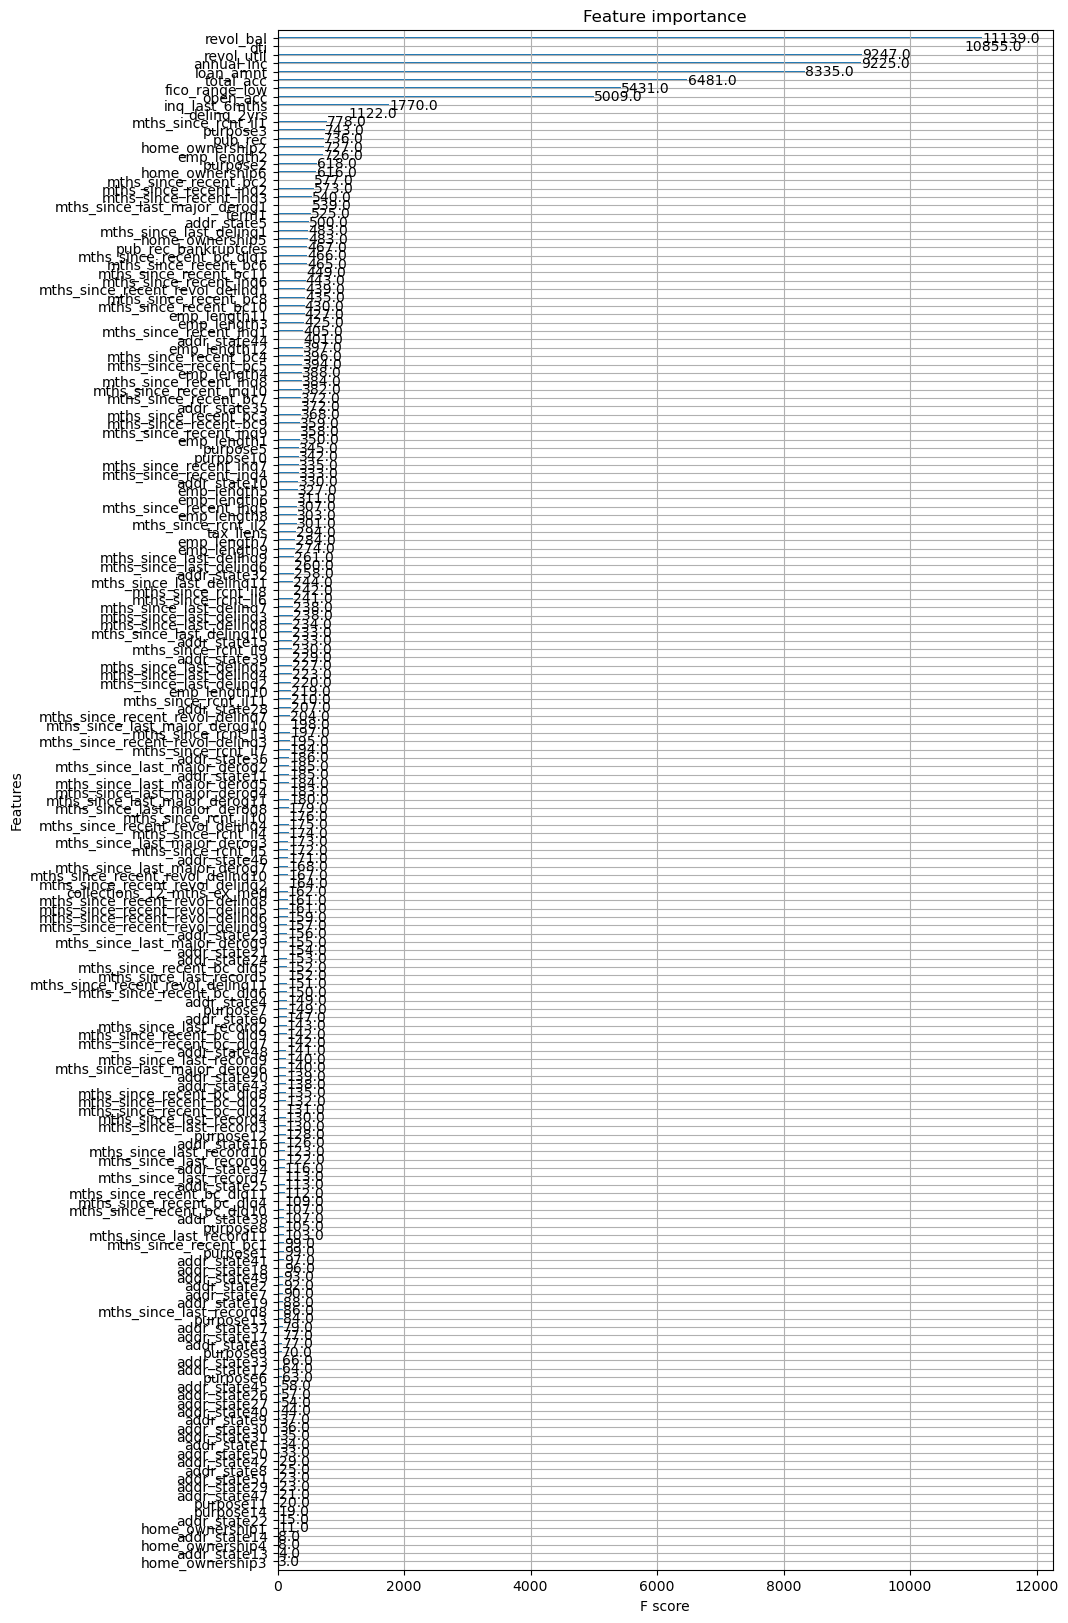

In [39]:
# 피쳐별 중요도 시각화. 기본적으로 f1 스코어 사용. 
from xgboost import plot_importance

plt.rc("figure", figsize=(10,20))

plot_importance(xgb_model)
plt.show()